In [1]:
%pip install Sastrawi

In [2]:
import nltk

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LimDaenery93\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import joblib
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
df = pd.read_csv('smart_locker_reviews.csv', sep=";")
df

,review,sentiment
0,"Kualitas smart locker ini sangat buruk, sering...",Negative
1,Desain smart locker sangat modern dan menarik.,Positive
2,Smart locker ini memiliki fitur yang cukup sta...,Neutral
3,"Keamanan smart locker ini sangat tinggi, saya ...",Positive
4,Smart locker ini sering tidak bisa diakses saa...,Negative
...,...,...
1957,Kinerja face recognition-nya enggak bagus,Negative
1958,Kinerja face recognition-nya enggak jelek dan ...,Neutral
1959,Efisiensi lokernya enggak jelek,Positive
1960,Efisiensi lokernya enggak bagus,Negative


### Case Folding

In [3]:
df['review'] = df['review'].astype(str).str.lower()
df['review']

0       kualitas smart locker ini sangat buruk, sering...
1          desain smart locker sangat modern dan menarik.
2       smart locker ini memiliki fitur yang cukup sta...
3       keamanan smart locker ini sangat tinggi, saya ...
4       smart locker ini sering tidak bisa diakses saa...
                              ...                        
1957            kinerja face recognition-nya enggak bagus
1958    kinerja face recognition-nya enggak jelek dan ...
1959                      efisiensi lokernya enggak jelek
1960                      efisiensi lokernya enggak bagus
1961     efisiensi lokernya enggak jelek dan enggak bagus
Name: review, Length: 1962, dtype: object

### Cleansing

In [4]:
def clean_text(text):
    # Menghilangkan karakter spesial dan tanda baca.
    text = re.sub(r'[^\w\s]', '', text)
    # Menghilangkan angka.
    text = re.sub(r'\d+', '', text)
    # Menghilangkan spasi ganda
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['cleaned_review'] = df['review'].apply(clean_text)
df['cleaned_review']

0       kualitas smart locker ini sangat buruk sering ...
1           desain smart locker sangat modern dan menarik
2       smart locker ini memiliki fitur yang cukup sta...
3       keamanan smart locker ini sangat tinggi saya m...
4       smart locker ini sering tidak bisa diakses saa...
                              ...                        
1957             kinerja face recognitionnya enggak bagus
1958    kinerja face recognitionnya enggak jelek dan e...
1959                      efisiensi lokernya enggak jelek
1960                      efisiensi lokernya enggak bagus
1961     efisiensi lokernya enggak jelek dan enggak bagus
Name: cleaned_review, Length: 1962, dtype: object

### Normalisasi Teks

In [5]:
import json

def read_normalization_dict(file_path):
    with open(file_path, 'r') as file:
        normalization_dict = json.load(file)
    return normalization_dict

normalization_dict = read_normalization_dict('combined_slang_words.json')

def normalize_text(text, normalization_dict):
    words = text.split()
    normalized_words = [normalization_dict.get(word, word) for word in words]
    return ' '.join(normalized_words)

df['normalized_review'] = df['cleaned_review'].apply(lambda x: normalize_text(x, normalization_dict))
df['normalized_review']

0       kualitas smart locker ini sangat buruk sering ...
1           desain smart locker sangat modern dan menarik
2       smart locker ini memiliki fitur yang cukup sta...
3       keamanan smart locker ini sangat tinggi saya m...
4       smart locker ini sering tidak bisa diakses saa...
                              ...                        
1957              kinerja face recognitionnya tidak bagus
1958    kinerja face recognitionnya tidak jelek dan ti...
1959                       efisiensi lokernya tidak jelek
1960                       efisiensi lokernya tidak bagus
1961       efisiensi lokernya tidak jelek dan tidak bagus
Name: normalized_review, Length: 1962, dtype: object

### Tokenizing

In [6]:
df['tokens'] = df['normalized_review'].apply(word_tokenize)
df['tokens']

0       [kualitas, smart, locker, ini, sangat, buruk, ...
1       [desain, smart, locker, sangat, modern, dan, m...
2       [smart, locker, ini, memiliki, fitur, yang, cu...
3       [keamanan, smart, locker, ini, sangat, tinggi,...
4       [smart, locker, ini, sering, tidak, bisa, diak...
                              ...                        
1957        [kinerja, face, recognitionnya, tidak, bagus]
1958    [kinerja, face, recognitionnya, tidak, jelek, ...
1959                  [efisiensi, lokernya, tidak, jelek]
1960                  [efisiensi, lokernya, tidak, bagus]
1961    [efisiensi, lokernya, tidak, jelek, dan, tidak...
Name: tokens, Length: 1962, dtype: object

### Stopword Removal

In [7]:
stop_words = set(stopwords.words('indonesian'))
stop_words.discard("tidak")

def remove_stopwords(text):
    return [word for word in text if word not in stop_words]

df['tokens'] = df['tokens'].apply(remove_stopwords)

### Stemming

In [8]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stem_tokenizer(text):
    return [stemmer.stem(word) for word in text]

df['tokens'] = df['tokens'].apply(stem_tokenizer)
df['processed_review'] = df['tokens'].apply(lambda x: ' '.join(x))
df['processed_review']

0                 kualitas smart locker buruk rusak tidak
1                        desain smart locker modern tarik
2                        smart locker milik fitur standar
3                     aman smart locker barangbarang aman
4                          smart locker tidak akses butuh
                              ...                        
1957                kerja face recognitionnya tidak bagus
1958    kerja face recognitionnya tidak jelek tidak bagus
1959                       efisiensi lokernya tidak jelek
1960                       efisiensi lokernya tidak bagus
1961           efisiensi lokernya tidak jelek tidak bagus
Name: processed_review, Length: 1962, dtype: object

### Pembobotan TF-IDF

In [9]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.7, min_df=1, ngram_range=(1, 2))
tfidf_matrix = tfidf_vectorizer.fit_transform(df['processed_review'])

In [10]:
# Menampilkan 10 kata dengan nilai IDF tertinggi
freqs = tfidf_matrix.sum(axis=0)
idf_values = tfidf_vectorizer.idf_
word_idf = dict(zip(tfidf_vectorizer.get_feature_names_out(), idf_values))

top_idf_words = sorted(word_idf.items(), key=lambda x: x[1], reverse=True)[:10]
for word, idf in top_idf_words:
    print(f'Kata: {word}, Kemunculan: {idf}')

Kata: adaptasi, Kemunculan: 7.889082013716516
Kata: akses antri, Kemunculan: 7.889082013716516
Kata: akses efisien, Kemunculan: 7.889082013716516
Kata: akses gampang, Kemunculan: 7.889082013716516
Kata: akses kali, Kemunculan: 7.889082013716516
Kata: akses kendala, Kemunculan: 7.889082013716516
Kata: akses kesel, Kemunculan: 7.889082013716516
Kata: akses kunci, Kemunculan: 7.889082013716516
Kata: akses modern, Kemunculan: 7.889082013716516
Kata: akses ngecewain, Kemunculan: 7.889082013716516


### klasifikasi SVM

In [11]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, df['sentiment'], test_size=0.2, random_state=42)

model = svm.SVC(C=10, kernel='rbf', gamma=0.1)
model.fit(X_train, y_train)
print(f"Accuracy : {model.score(X_test, y_test)}")

Accuracy : 0.8575063613231552


In [12]:
pred = model.predict(X_test)
pred

array(['Positive', 'Negative', 'Neutral', 'Negative', 'Negative',
       'Positive', 'Positive', 'Neutral', 'Neutral', 'Positive',
       'Neutral', 'Neutral', 'Negative', 'Positive', 'Positive',
       'Neutral', 'Negative', 'Neutral', 'Neutral', 'Negative',
       'Positive', 'Neutral', 'Neutral', 'Negative', 'Negative',
       'Positive', 'Positive', 'Neutral', 'Negative', 'Negative',
       'Negative', 'Positive', 'Positive', 'Positive', 'Positive',
       'Negative', 'Neutral', 'Positive', 'Neutral', 'Positive',
       'Neutral', 'Negative', 'Negative', 'Neutral', 'Negative',
       'Positive', 'Negative', 'Positive', 'Positive', 'Neutral',
       'Neutral', 'Negative', 'Negative', 'Negative', 'Positive',
       'Positive', 'Neutral', 'Positive', 'Neutral', 'Positive',
       'Positive', 'Negative', 'Neutral', 'Neutral', 'Neutral',
       'Positive', 'Positive', 'Neutral', 'Neutral', 'Negative',
       'Negative', 'Positive', 'Negative', 'Positive', 'Positive',
       'Negative', 

In [13]:
print(f"Accuracy : {model.score(X_test, y_test)}")

Accuracy : 0.8575063613231552


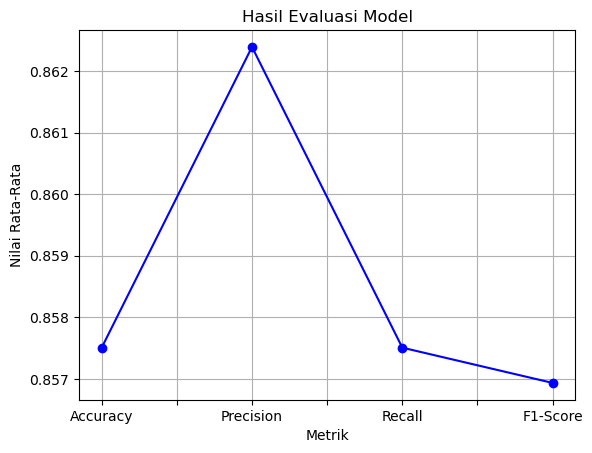

In [14]:
pred = model.predict(X_test)
acc_score = accuracy_score(y_test, pred) 
pre_score = precision_score(y_test, pred, average='weighted')
rec_score = recall_score(y_test, pred, average='weighted')
f_score = f1_score(y_test, pred, average='weighted')

scores = {
    'Accuracy': acc_score,
    'Precision': pre_score,
    'Recall': rec_score, 
    'F1-Score': f_score
}

eval_df = pd.DataFrame.from_dict(scores, orient='index', columns=['Score']) 

eval_df['Score'].plot(kind='line', marker='o', color='blue') 

plt.title('Hasil Evaluasi Model')
plt.xlabel('Metrik') 
plt.ylabel('Nilai Rata-Rata')
plt.grid(True) 

plt.show()

In [15]:
# Evaluasi pada training set
y_train_pred = model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Training Accuracy:", train_accuracy)
print("Training Classification Report:")
print(classification_report(y_train, y_train_pred))

# Evaluasi pada testing set
y_test_pred = model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Testing Accuracy:", test_accuracy)
print("Testing Classification Report:")
print(classification_report(y_test, y_test_pred))

Training Accuracy: 0.9719566602931804
Training Classification Report:
              precision    recall  f1-score   support

    Negative       0.96      0.97      0.97       517
     Neutral       0.99      0.94      0.97       518
    Positive       0.97      1.00      0.98       534

    accuracy                           0.97      1569
   macro avg       0.97      0.97      0.97      1569
weighted avg       0.97      0.97      0.97      1569

Testing Accuracy: 0.8575063613231552
Testing Classification Report:
              precision    recall  f1-score   support

    Negative       0.89      0.80      0.85       137
     Neutral       0.88      0.83      0.86       136
    Positive       0.80      0.95      0.87       120

    accuracy                           0.86       393
   macro avg       0.86      0.86      0.86       393
weighted avg       0.86      0.86      0.86       393



In [17]:
def preprocess_review(review):
    review = review.lower()
    clean_review = clean_text(review)
    normalize_review = normalize_text(clean_review, normalization_dict)
    tokens = word_tokenize(normalize_review)
    tokens = remove_stopwords(tokens)
    tokens = stem_tokenizer(tokens)
    return ' '.join(tokens)

def predict_sentiment(review):
    preprocessed_review = preprocess_review(review)
    tfidf_review = tfidf_vectorizer.transform([preprocessed_review])
    sentiment = model.predict(tfidf_review)
    return sentiment[0]

new_reviews = [
    "lokernya gk jelek",
    "lokernya tidak bagus",
    "lokernya gk bagus dan gk jelek"
]

for review in new_reviews:
    sentiment = predict_sentiment(review)
    print(f"Review: {review}\nPredicted Sentiment: {sentiment}\n")

Review: lokernya gk jelek
Predicted Sentiment: Positive

Review: lokernya tidak bagus
Predicted Sentiment: Negative

Review: lokernya gk bagus dan gk jelek
Predicted Sentiment: Neutral



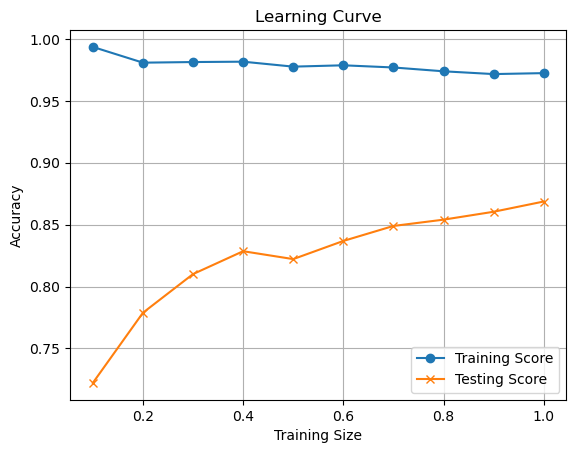

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, X, y, cv=None, train_sizes=np.linspace(0.1, 1.0, 10)):
    train_scores, test_scores = [], []
    for train_size in train_sizes:
        _, train_score, test_score = learning_curve(estimator, X, y, cv=cv, train_sizes=[train_size])
        train_scores.append(train_score.mean())
        test_scores.append(test_score.mean())
    plt.plot(train_sizes, train_scores, label='Training Score', marker='o')
    plt.plot(train_sizes, test_scores, label='Testing Score', marker='x')
    plt.title('Learning Curve')
    plt.xlabel('Training Size')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

X_train, X_val, y_train, y_val = train_test_split(tfidf_matrix, df['sentiment'], test_size=0.2, random_state=42)
model = svm.SVC(C=10, kernel='rbf', gamma=0.1)

plot_learning_curve(model, X_train, y_train, cv=5)
plt.show()

In [19]:
joblib.dump(model, 'sentiment.pkl')
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']

### Find Best Parameters

In [357]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'tfidf__max_df': [0.7, 0.75, 0.8, 0.85, 0.9, 0.95],
    'tfidf__min_df': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'svm__C': [0.1, 1, 10],
    'svm__gamma': [0.01, 0.1, 1],
    'svm__kernel': ['linear', 'rbf', 'poly', 'sigmoid']
}

In [358]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svm', svm.SVC())
])

In [359]:
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(df['processed_review'], df['sentiment'])

Fitting 5 folds for each of 4320 candidates, totalling 21600 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('svm', SVC())]),
             n_jobs=-1,
             param_grid={'svm__C': [0.1, 1, 10], 'svm__gamma': [0.01, 0.1, 1],
                         'svm__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
                         'tfidf__max_df': [0.7, 0.75, 0.8, 0.85, 0.9, 0.95],
                         'tfidf__min_df': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'tfidf__ngram_range': [(1, 1), (1, 2)]},
             verbose=2)

In [361]:
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

Best parameters found:  {'svm__C': 10, 'svm__gamma': 0.1, 'svm__kernel': 'rbf', 'tfidf__max_df': 0.7, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 2)}
Best cross-validation score:  0.8358402139481746


In [174]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'tfidf__max_df': [0.7, 0.75, 0.8, 0.85, 0.9, 0.95],
    'tfidf__min_df': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'svm__C': np.logspace(-2, 1, 4),
    'svm__gamma': np.logspace(-2, 1, 4),
    'svm__kernel': ['linear', 'rbf', 'poly', 'sigmoid']
}

In [175]:
random_search = RandomizedSearchCV(pipeline, param_distributions=param_dist, n_iter=4320, cv=5, n_jobs=-1, verbose=2, random_state=42)
random_search.fit(df['processed_review'], df['sentiment'])

Fitting 5 folds for each of 4320 candidates, totalling 21600 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                             ('svm', SVC())]),
                   n_iter=4320, n_jobs=-1,
                   param_distributions={'svm__C': array([ 0.01,  0.1 ,  1.  , 10.  ]),
                                        'svm__gamma': array([ 0.01,  0.1 ,  1.  , 10.  ]),
                                        'svm__kernel': ['linear', 'rbf', 'poly',
                                                        'sigmoid'],
                                        'tfidf__max_df': [0.7, 0.75, 0.8, 0.85,
                                                          0.9, 0.95],
                                        'tfidf__min_df': [1, 2, 3, 4, 5, 6, 7,
                                                          8, 9, 10],
                                        'tfidf__ngram_range': [(1, 1), (1, 2)]},
                   random_state=42, verbose=2)

In [176]:
print("Best parameters found: ", random_search.best_params_)
print("Best cross-validation score: ", random_search.best_score_)

Best parameters found:  {'tfidf__ngram_range': (1, 2), 'tfidf__min_df': 1, 'tfidf__max_df': 0.85, 'svm__kernel': 'rbf', 'svm__gamma': 0.1, 'svm__C': 10.0}
Best cross-validation score:  0.8112820512820512
